This notebook tests out this fix for estimating treatment effect in regularised linear models:

Hahn, P.R., Carvalho, C.M., Puelz, D., He, J., 2018. Regularization and Confounding in Linear Regression for Treatment Effect Estimation. Bayesian Anal. 13. https://doi.org/10.1214/16-BA1044


In [1]:
import numpy as np
import jax.numpy as jnp
import pandas as pd

from jax import grad
from jax.scipy.optimize import minimize
from scipy.linalg import solve

from sklearn.linear_model import LinearRegression, BayesianRidge, Lasso, Ridge, ARDRegression
from sklearn.inspection import plot_partial_dependence
from sklearn.base import BaseEstimator
from sklearn.metrics import r2_score

from twostageridge import TwoStageRidge

# Generate the data

In [2]:
N = 1000


# Confounders - X
mu_x = np.zeros(4)
cov_x = np.array([
    [ 1.0,  0.3, -0.1, 0.0],
    [ 0.3,  1.0, -0.5, 0.0],
    [-0.1, -0.5,  1.0, 0.8],
    [ 0.0,  0.0,  0.8, 1.0]
])


# Treatment - Z
gamma = np.array([-2., 1., 0., 0.5])
sig_eps = 0.1


# Target - Y
alpha = 0.4
beta = np.array([.5, -1, 1.5, 0.])
sig_nu = 0.6

# Generation function
def generate_data():
    X = np.random.multivariate_normal(mean=mu_x, cov=cov_x, size=N)
    Z = X @ gamma + sig_eps * np.random.randn(N)
    Y = alpha * Z + X @ beta + sig_nu * np.random.randn(N)
    W = np.hstack((Z[:, np.newaxis], X))
    return W, Y

# Generate bias comparison results

In [3]:
S = 20
models = {
    "ols": LinearRegression(),
    "lasso": Lasso(alpha=1e-2),
    "ridge": Ridge(alpha=1.),
    "bayes": BayesianRidge(),
    #"ard": ARDRegression(),
    "hahn": TwoStageRidge(treatment_index=0, regulariser1=.1, regulariser2=.1)
}

scores = {k: [] for k in models.keys()}
biases = {k: [] for k in models.keys()}
errors = {k: [] for k in models.keys()}

for s in range(S):
    W, Y = generate_data()
    
    for name, model in models.items():
        model.fit(W, Y)
        bias = alpha - model.coef_[0]
        error = bias**2
        
        scores[name].append(model.score(W, Y))
        biases[name].append(bias)
        errors[name].append(error)
        
    print('.', end='')
print()
        
        
scores = {k: np.mean(v) for k, v in scores.items()}
biases = {k: np.mean(v) for k, v in biases.items()}
errors = {k: np.sqrt(np.mean(v)) for k, v in errors.items()}


results = pd.DataFrame({
    "scores": scores,
    "biases": biases,
    "errors": errors
})

results

....................


,scores,biases,errors
ols,0.923514,-0.069141,0.225754
lasso,0.923147,0.250518,0.250830
ridge,0.923433,0.106157,0.169427
bayes,0.923491,0.027762,0.186800
hahn,0.923513,-0.069128,0.225760


In [4]:
models["hahn"].score_stage1(W)

0.9976198399467421

# Help get an intuition for how this works...

Ridge regression bias
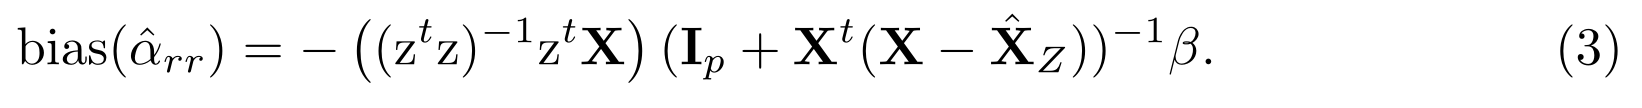

Reparameterised ridge regression bias
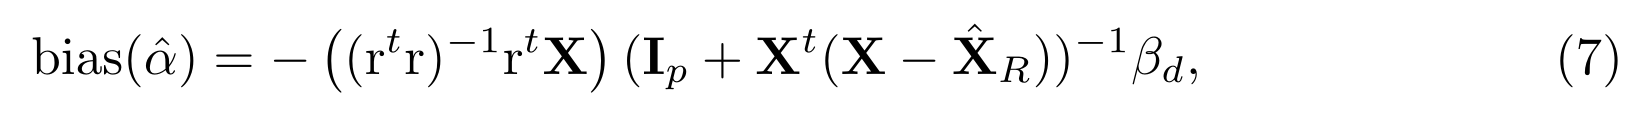

where
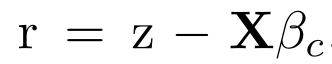

The term $(Z^\top Z)^{-1} Z^\top \mathbf{X}$ should be larger than $(R^\top R)^{-1} R^\top \mathbf{X}$ since R is independent from X.

In [5]:
W, Y = generate_data()
Z, X = W[:, 1], W[:, 1:]
β_c = models["hahn"].beta_c_
R = Z - np.hstack((X, np.ones((N, 1)))) @ β_c

In [6]:
# Regular ridge
zzzX = Z @ X / np.sum(Z**2)
print(np.linalg.norm(zzzX))
zzzX

1.0491649997704742


array([ 1.        ,  0.28420714, -0.13514876, -0.0413317 ])

In [7]:
# Reparam ridge
rrrX = R @ X / np.sum(R**2)
print(np.linalg.norm(rrrX))
rrrX

0.32528222937686874


array([ 0.31458095, -0.01991996, -0.03357695, -0.07295984])

In [8]:
β = models["hahn"].beta_
β_d = models["hahn"].beta_d_
α = models["hahn"].alpha_
print(f"β + α β_c = {β + α * β_c}")
print(f"β_d = {β_d}")

β + α β_c = [-0.35618454 -0.56281226  1.49486209  0.20602191  0.01903868]
β_d = [-0.28632349 -0.59777305  1.49478994  0.18847016  0.01905658]


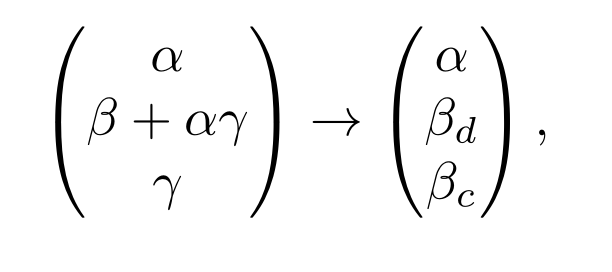